# Attention implementation for Dense Layer in Keras v2

reference: https://github.com/philipperemy/keras-attention-mechanism

In [37]:
import numpy as np
import keras
from keras.layers import Input, multiply #, Dense, merge
# from keras.models import *

In [38]:
np.random.seed(1337)

In [39]:
input_dim = 32

In [43]:
def build_model():
    _inputs = Input(shape=(input_dim,)) 
    
    # Attention 부분 시작-
    
    # attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    # input_shape을 선언해주지 않으니 error
    _attention_probs = Dense(input_dim, activation='softmax', input_shape=(input_dim, ), name='attention_vec')(_inputs)
    
    # attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # mode='mul'은 deprecated and removed -> keras.layers.merge, add를 사용할 것!
    _attention_mul = multiply([_inputs, _attention_probs])
    
    # Attention 부분 끝-
    
    _attention_mul = Dense(64)(_attention_mul)
    _output = Dense(1, activation='sigmoid')(_attention_mul)
    
    # _model = Model(input=[_inputs], output=_output)
    # 'UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`'이 떠서 Keras 2에 맞게 수정...
    _model = Model(inputs=[_inputs], outputs=_output)
                                                                                    
    return _model

In [44]:
def get_data(n, input_dim, attention_column=1):
    """
    n: the number of samples to retrieve.
    input_dim: the number of dimensions of each element in the series.
    attention_column: the column linked to the target. Everything else is purely random.
    return [model inputs, model targets]
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y

In [48]:
N = 10000
inputs, outputs = get_data(N, input_dim)
   
m = build_model()
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print (m.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_10[0][0]                   
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 32)           0           input_10[0][0]                   
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           2112        multiply_5[0][0]                 
__________

In [49]:
m.fit([inputs], outputs, epochs=20, batch_size=64, validation_split=0.5)

Train on 5000 samples, validate on 5000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 181us/step - loss: 0.6846 - acc: 0.6142 - val_loss: 0.6742 - val_acc: 0.6646
Epoch 2/20
5000/5000 [==============================] - 0s 54us/step - loss: 0.6472 - acc: 0.7252 - val_loss: 0.6140 - val_acc: 0.7746
Epoch 3/20
5000/5000 [==============================] - 0s 51us/step - loss: 0.5598 - acc: 0.7976 - val_loss: 0.5152 - val_acc: 0.7704
Epoch 4/20
5000/5000 [==============================] - 0s 54us/step - loss: 0.4515 - acc: 0.8220 - val_loss: 0.4124 - val_acc: 0.8338
Epoch 5/20
5000/5000 [==============================] - 0s 54us/step - loss: 0.3462 - acc: 0.8704 - val_loss: 0.3081 - val_acc: 0.8852
Epoch 6/20
5000/5000 [==============================] - 0s 55us/step - loss: 0.2382 - acc: 0.9196 - val_loss: 0.1962 - val_acc: 0.9422
Epoch 7/20
5000/5000 [==============================] - 0s 50us/step - loss: 0.1329 - acc: 0.9680 - val_loss: 0.0972 - val_acc: 0.9804
Epoch 

In [71]:
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    input_shape = model.input

    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name] # all layer outputs

    funcs = [K.function([input_shape] + [K.learning_phase()], [out]) for out in outputs] # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [76]:
testing_inputs, testing_outputs = get_data(1, input_dim)

# Attention vector corresponds to the second matrix.
# The first one is the Inputs output.
attention_vector = get_activations(m, testing_inputs, print_shape_only=True, layer_name='attention_vec')[0].flatten()

print('attention =', attention_vector)

----- activations -----
(1, 32)
attention = [0.01561181 0.48209226 0.01694034 0.01759651 0.01524514 0.01651226
 0.03915219 0.01921966 0.04387974 0.01225476 0.01632706 0.0137192
 0.01716046 0.01732742 0.0245535  0.02061529 0.01161353 0.00935418
 0.01072566 0.01354322 0.02477677 0.01679133 0.02193005 0.01080894
 0.00913156 0.01350175 0.01253633 0.00852914 0.01153062 0.00868106
 0.01241545 0.01592278]


In [104]:
from matplotlib import pyplot as plt
import pandas as pd 

Text(0, 0.5, 'attention value')

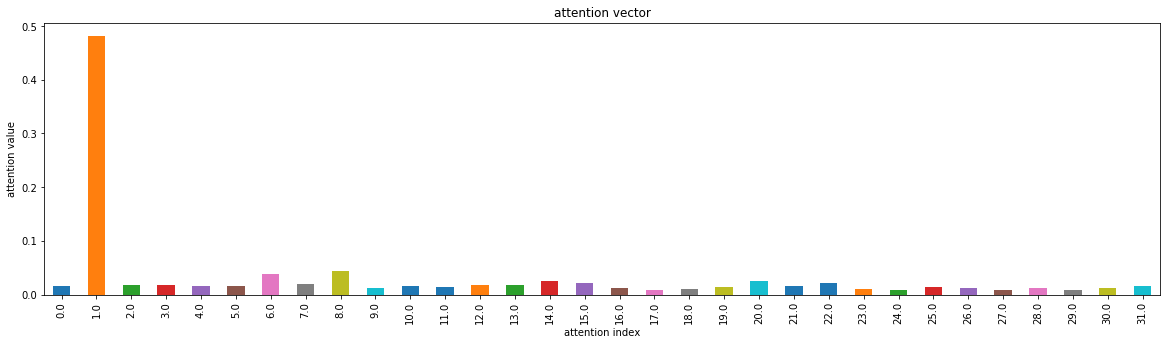

In [121]:
x = np.linspace(0, 31, num=32)

s = pd.Series(attention_vector, x)

s.plot.bar(figsize=(20,5))
plt.title('attention vector')
plt.xlabel('attention index')
plt.ylabel('attention value')